# Multi-Modal PPG-GNN Heart Rate Prediction with Checkpointing

**Enhanced version with:**
- Automatic checkpoint saving every 50 epochs
- Resume from checkpoint capability
- Best model tracking based on MAE
- Hyperparameter tuning with model saving
- Optimized for long training sessions (8-12 hours)

In [1]:
# ============================================================================
# DEPENDENCY INSTALLATION
# Run this cell once to install all required packages for GNN
# ============================================================================

# Core dependencies
%pip install numpy scipy scikit-learn pandas matplotlib seaborn -q

# PyTorch (CPU version - change to GPU version if you have CUDA)
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu -q

# PyTorch Geometric and dependencies
%pip install torch-geometric -q
%pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html -q

print("✅ All dependencies installed successfully!")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ All dependencies installed successfully!


In [2]:
import os
import pickle
import numpy as np

# Path to your dataset
DATASET_PATH = r"C:\Users\pedri\Documents\ResearchData\Data\PPG_FieldStudy"

def load_ppg_dataset(dataset_path):
    """
    Load synchronized PPG dataset from all subject .pkl files.
    
    Returns:
        dataset (dict): 
            {
              "S1": {"BVP": np.array, "ACC": np.array, "HR": np.array, "Activity": np.array},
              "S2": {...},
              ...
            }
    """
    dataset = {}
    
    for subj in range(1, 16):  # Subjects S1 ... S15
        subj_id = f"S{subj}"
        subj_folder = os.path.join(dataset_path, subj_id)
        pkl_file = os.path.join(subj_folder, f"{subj_id}.pkl")
        
        if not os.path.exists(pkl_file):
            print(f"⚠️ Missing file: {pkl_file}")
            continue
        
        # Load the .pkl file
        with open(pkl_file, "rb") as f:
            data = pickle.load(f, encoding="latin1")  # latin1 ensures compatibility
        
        # Extract signals + labels
        bvp = np.array(data["signal"]["wrist"]["BVP"])   # 64 Hz PPG
        acc = np.array(data["signal"]["wrist"]["ACC"])   # 32 Hz ACC (3D)
        hr  = np.array(data["label"])                    # ECG-derived HR (windowed)
        act = np.array(data["activity"])                 # Activity ID
        
        dataset[subj_id] = {
            "BVP": bvp,
            "ACC": acc,
            "HR": hr,
            "Activity": act
        }
        
        print(f"✅ Loaded {subj_id}: BVP {bvp.shape}, ACC {acc.shape}, HR {hr.shape}, Activity {act.shape}")
    
    return dataset

# Run loader
dataset = load_ppg_dataset(DATASET_PATH)

# Example: check S1 keys
print("\nKeys for S1:", dataset["S1"].keys())

✅ Loaded S1: BVP (589568, 1), ACC (294784, 3), HR (4603,), Activity (36848, 1)
✅ Loaded S2: BVP (525120, 1), ACC (262560, 3), HR (4099,), Activity (32820, 1)
✅ Loaded S3: BVP (559424, 1), ACC (279712, 3), HR (4367,), Activity (34964, 1)
✅ Loaded S4: BVP (585600, 1), ACC (292800, 3), HR (4572,), Activity (36600, 1)
✅ Loaded S5: BVP (595520, 1), ACC (297760, 3), HR (4649,), Activity (37220, 1)
✅ Loaded S6: BVP (336000, 1), ACC (168000, 3), HR (2622,), Activity (21000, 1)
✅ Loaded S7: BVP (597952, 1), ACC (298976, 3), HR (4668,), Activity (37372, 1)
✅ Loaded S8: BVP (517120, 1), ACC (258560, 3), HR (4037,), Activity (32320, 1)
✅ Loaded S9: BVP (547840, 1), ACC (273920, 3), HR (4277,), Activity (34240, 1)
✅ Loaded S10: BVP (681472, 1), ACC (340736, 3), HR (5321,), Activity (42592, 1)
✅ Loaded S11: BVP (579072, 1), ACC (289536, 3), HR (4521,), Activity (36192, 1)
✅ Loaded S12: BVP (506496, 1), ACC (253248, 3), HR (3954,), Activity (31656, 1)
✅ Loaded S13: BVP (584704, 1), ACC (292352, 3), H

In [3]:
import numpy as np

def segment_signal(signal, window_size, step_size):
    """
    Segment 1D or 2D signal into overlapping windows.
    
    Args:
        signal (np.array): shape (N,) or (N, D)
        window_size (int): number of samples per window
        step_size (int): number of samples to move the window
    
    Returns:
        windows (np.array): shape (#windows, window_size, D)
    """
    n_samples = signal.shape[0]
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    n_dims = signal.shape[1]
    
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(signal[start:end])
    return np.array(windows)

def preprocess_dataset(dataset):
    """
    For each subject, segment BVP and ACC signals into 8s windows
    with 2s shift and align them with HR labels.
    
    Returns:
        processed (dict): {subject: {"BVP": ..., "ACC": ..., "HR": ..., "Activity": ...}}
    """
    processed = {}
    
    # Parameters
    bvp_fs = 64   # Hz
    acc_fs = 32   # Hz
    win_time = 8  # seconds
    step_time = 2 # seconds
    
    bvp_win = win_time * bvp_fs   # 512 samples
    bvp_step = step_time * bvp_fs # 128 samples
    
    acc_win = win_time * acc_fs   # 256 samples
    acc_step = step_time * acc_fs # 64 samples
    
    for subj, data in dataset.items():
        bvp = data["BVP"].squeeze()    # (N,)
        acc = data["ACC"]              # (N, 3)
        hr  = data["HR"]               # (#windows,)
        act = data["Activity"]         # (#activity_samples, 1) at 4 Hz
        
        # Segment BVP + ACC
        bvp_windows = segment_signal(bvp, bvp_win, bvp_step)
        acc_windows = segment_signal(acc, acc_win, acc_step)
        
        # Align to HR length
        min_len = min(len(hr), len(bvp_windows), len(acc_windows))
        bvp_windows = bvp_windows[:min_len]
        acc_windows = acc_windows[:min_len]
        hr = hr[:min_len]
        
        processed[subj] = {
            "BVP": bvp_windows,   # (N_windows, 512, 1)
            "ACC": acc_windows,   # (N_windows, 256, 3)
            "HR": hr,             # (N_windows,)
            "Activity": act       # Keep raw activity for now
        }
        
        print(f"✅ {subj}: {bvp_windows.shape}, {acc_windows.shape}, HR {hr.shape}")
    
    return processed

# Run preprocessing
processed_dataset = preprocess_dataset(dataset)

# Example check
print("\nS1 processed shapes:")
print("BVP:", processed_dataset["S1"]["BVP"].shape)
print("ACC:", processed_dataset["S1"]["ACC"].shape)
print("HR:", processed_dataset["S1"]["HR"].shape)

✅ S1: (4603, 512, 1), (4603, 256, 3), HR (4603,)
✅ S2: (4099, 512, 1), (4099, 256, 3), HR (4099,)
✅ S3: (4367, 512, 1), (4367, 256, 3), HR (4367,)
✅ S4: (4572, 512, 1), (4572, 256, 3), HR (4572,)
✅ S5: (4649, 512, 1), (4649, 256, 3), HR (4649,)
✅ S6: (2622, 512, 1), (2622, 256, 3), HR (2622,)
✅ S7: (4668, 512, 1), (4668, 256, 3), HR (4668,)
✅ S8: (4037, 512, 1), (4037, 256, 3), HR (4037,)
✅ S9: (4277, 512, 1), (4277, 256, 3), HR (4277,)
✅ S10: (5321, 512, 1), (5321, 256, 3), HR (5321,)
✅ S11: (4521, 512, 1), (4521, 256, 3), HR (4521,)
✅ S12: (3954, 512, 1), (3954, 256, 3), HR (3954,)
✅ S13: (4565, 512, 1), (4565, 256, 3), HR (4565,)
✅ S14: (4476, 512, 1), (4476, 256, 3), HR (4476,)
✅ S15: (3966, 512, 1), (3966, 256, 3), HR (3966,)

S1 processed shapes:
BVP: (4603, 512, 1)
ACC: (4603, 256, 3)
HR: (4603,)


In [4]:
import numpy as np
import scipy.stats as stats
from scipy.signal import welch

def extract_bvp_features(window, fs=64):
    """Extract time + frequency features from one BVP window (512 samples)."""
    feats = []
    
    # Time-domain
    feats.append(np.mean(window))
    feats.append(np.std(window))
    feats.append(np.min(window))
    feats.append(np.max(window))
    feats.append(stats.skew(window))
    feats.append(stats.kurtosis(window))
    
    # Frequency-domain (Welch PSD)
    freqs, psd = welch(window, fs=fs, nperseg=256)
    
    # Bands: low freq (0.04-0.15 Hz), high freq (0.15-0.4 Hz)
    lf_band = np.logical_and(freqs >= 0.04, freqs < 0.15)
    hf_band = np.logical_and(freqs >= 0.15, freqs < 0.4)
    
    lf_power = np.sum(psd[lf_band])
    hf_power = np.sum(psd[hf_band])
    
    feats.append(lf_power)
    feats.append(hf_power)
    
    # Dominant frequency
    dom_idx = np.argmax(psd)
    feats.append(freqs[dom_idx])
    feats.append(psd[dom_idx])
    
    return np.array(feats)

def safe_corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0,1]

def extract_acc_features(window, fs=32):
    """Extract motion features from one ACC window (256×3)."""
    feats = []
    for i in range(3):  # x, y, z axes
        axis = window[:, i]
        feats.append(np.mean(axis))
        feats.append(np.std(axis))
        feats.append(np.min(axis))
        feats.append(np.max(axis))
        feats.append(np.sum(axis**2))  # energy
    
    # Cross-axis correlations
    feats.append(safe_corrcoef(window[:,0], window[:,1]))
    feats.append(safe_corrcoef(window[:,0], window[:,2]))
    feats.append(safe_corrcoef(window[:,1], window[:,2]))
    
    return np.array(feats)

def build_feature_dataset(processed_dataset):
    """
    Extract features from BVP + ACC for all subjects.
    Returns:
        X (np.array): features [N_windows, N_features]
        y (np.array): HR labels [N_windows]
        subjects (list): subject IDs per window
    """
    X, y, subjects = [], [], []
    
    for subj, data in processed_dataset.items():
        bvp_windows = data["BVP"]
        acc_windows = data["ACC"]
        hr_labels = data["HR"]
        
        for i in range(len(hr_labels)):
            bvp_feats = extract_bvp_features(bvp_windows[i].squeeze())
            acc_feats = extract_acc_features(acc_windows[i])
            feats = np.concatenate([bvp_feats, acc_feats])
            
            X.append(feats)
            y.append(hr_labels[i])
            subjects.append(subj)
    
    return np.array(X), np.array(y), subjects

# Run feature extraction
X, y, subj_ids = build_feature_dataset(processed_dataset)

print("Feature dataset shape:", X.shape)
print("Labels shape:", y.shape)
print("Example feature vector length:", X.shape[1])

Feature dataset shape: (64697, 28)
Labels shape: (64697,)
Example feature vector length: 28


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_train_test(X, y, test_size=0.2, random_state=42):
    """
    Normalize features and split into train/test sets.
    """
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state
    )
    
    print("Train set:", X_train.shape, "Test set:", X_test.shape)
    return X_train, X_test, y_train, y_test, scaler

# Run preparation
X_train, X_test, y_train, y_test, scaler = prepare_train_test(X, y)

print("✅ Dataset ready for modeling")

Train set: (51757, 28) Test set: (12940, 28)
✅ Dataset ready for modeling


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
import numpy as np

def build_knn_graph(X_train, X_test, y_train, y_test, k=10):
    """
    Build k-NN graph from feature vectors for GNN training.
    
    Args:
        X_train: Training features (N_train, num_features)
        X_test: Test features (N_test, num_features)
        y_train: Training labels (HR values)
        y_test: Test labels (HR values)
        k: Number of nearest neighbors
    
    Returns:
        train_data: PyTorch Geometric Data object for training
        test_data: PyTorch Geometric Data object for testing
    """
    print(f"Building k-NN graph with k={k}...")
    
    # Build train graph
    # Create k-NN adjacency matrix (mode='connectivity' gives binary adjacency)
    train_adj = kneighbors_graph(X_train, k, mode='connectivity', include_self=False)
    train_edge_index = torch.tensor(np.array(train_adj.nonzero()), dtype=torch.long)
    
    # Convert to PyG Data object
    train_data = Data(
        x=torch.tensor(X_train, dtype=torch.float32),
        edge_index=train_edge_index,
        y=torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    )
    
    # Build test graph
    test_adj = kneighbors_graph(X_test, k, mode='connectivity', include_self=False)
    test_edge_index = torch.tensor(np.array(test_adj.nonzero()), dtype=torch.long)
    
    test_data = Data(
        x=torch.tensor(X_test, dtype=torch.float32),
        edge_index=test_edge_index,
        y=torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    )
    
    print(f"✅ Train graph: {train_data.num_nodes} nodes, {train_data.num_edges} edges")
    print(f"✅ Test graph: {test_data.num_nodes} nodes, {test_data.num_edges} edges")
    
    return train_data, test_data

# Build k-NN graphs for GNN
train_data, test_data = build_knn_graph(X_train, X_test, y_train, y_test, k=10)

print(f"\nTrain data shape: {train_data.x.shape}")
print(f"Test data shape: {test_data.x.shape}")

Building k-NN graph with k=10...
✅ Train graph: 51757 nodes, 517570 edges
✅ Test graph: 12940 nodes, 129400 edges

Train data shape: torch.Size([51757, 28])
Test data shape: torch.Size([12940, 28])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import os
from datetime import datetime
import json

class GAT_HR_Regressor(nn.Module):
    """
    Graph Attention Network (GAT) for Heart Rate Regression.
    
    Architecture:
    - 2 GAT layers with multi-head attention
    - Batch normalization and dropout for regularization
    - Final MLP for regression
    """
    def __init__(self, in_channels, hidden_channels=64, heads=4, dropout=0.3):
        super(GAT_HR_Regressor, self).__init__()
        
        # GAT Layer 1: multi-head attention
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        
        # GAT Layer 2: multi-head attention
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(hidden_channels * heads)
        
        # Regression head (MLP)
        self.fc1 = nn.Linear(hidden_channels * heads, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)
        
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # GAT Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # GAT Layer 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Regression head
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        
        return x

def train_gnn_epoch(model, data, optimizer, device):
    """Train GNN for one epoch."""
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = F.mse_loss(out, data.y.to(device))
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()

def evaluate_gnn(model, data, device):
    """Evaluate GNN on a dataset."""
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), data.edge_index.to(device))
        y_pred = out.cpu().numpy().squeeze()
        y_true = data.y.cpu().numpy().squeeze()
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        
    return mae, rmse, r2, y_pred

def save_checkpoint(checkpoint_path, epoch, model, optimizer, metrics, config, scaler, is_best=False):
    """Save a checkpoint with all necessary information for resuming training."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
        'config': config,
        'scaler': scaler,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'is_best': is_best
    }
    torch.save(checkpoint, checkpoint_path)
    return checkpoint_path

def load_checkpoint(checkpoint_path, model, optimizer=None, device='cpu'):
    """Load a checkpoint and restore training state."""
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"   Saved: {checkpoint['timestamp']}")
    if 'metrics' in checkpoint:
        print(f"   Test MAE: {checkpoint['metrics'].get('test_mae', 'N/A'):.2f} bpm")
    
    return checkpoint

def train_gnn(train_data, test_data, epochs=500, lr=0.001, hidden_channels=64, heads=4, dropout=0.3,
              checkpoint_freq=50, resume_from=None):
    """
    Train a GAT-based GNN for heart rate prediction with comprehensive checkpointing.
    
    Args:
        train_data: PyG Data object for training
        test_data: PyG Data object for testing
        epochs: Total number of epochs to train
        lr: Learning rate
        hidden_channels: Number of hidden channels in GAT layers
        heads: Number of attention heads
        dropout: Dropout rate
        checkpoint_freq: Save checkpoint every N epochs
        resume_from: Path to checkpoint to resume from (optional)
    
    Returns:
        model: Trained model
        y_pred: Test predictions
        checkpoint_dir: Directory where checkpoints are saved
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create checkpoint directory
    os.makedirs('saved_models/checkpoints', exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    checkpoint_dir = f'saved_models/checkpoints/training_{timestamp}'
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"📁 Checkpoints will be saved to: {checkpoint_dir}")
    
    # Model configuration
    in_channels = train_data.x.shape[1]
    config = {
        'in_channels': in_channels,
        'hidden_channels': hidden_channels,
        'heads': heads,
        'dropout': dropout,
        'lr': lr,
        'epochs': epochs,
        'k_neighbors': 10
    }
    
    # Save configuration
    config_path = os.path.join(checkpoint_dir, 'config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    # Initialize model
    model = GAT_HR_Regressor(in_channels, hidden_channels, heads, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    
    # Resume from checkpoint if specified
    start_epoch = 1
    best_test_mae = float('inf')
    
    if resume_from is not None:
        print(f"\n🔄 Resuming from checkpoint: {resume_from}")
        checkpoint = load_checkpoint(resume_from, model, optimizer, device)
        start_epoch = checkpoint['epoch'] + 1
        if 'metrics' in checkpoint:
            best_test_mae = checkpoint['metrics'].get('test_mae', float('inf'))
        print(f"   Resuming from epoch {start_epoch}\n")
    
    print(f"\n🚀 Training GAT-GNN from epoch {start_epoch} to {epochs}...")
    print(f"Model parameters: hidden={hidden_channels}, heads={heads}, dropout={dropout}")
    print(f"💾 Auto-save enabled: checkpoint every {checkpoint_freq} epochs\n")
    
    # Training history
    history = {
        'train_loss': [],
        'train_mae': [],
        'test_mae': [],
        'test_rmse': [],
        'test_r2': []
    }
    
    # Training loop
    for epoch in range(start_epoch, epochs + 1):
        loss = train_gnn_epoch(model, train_data, optimizer, device)
        history['train_loss'].append(loss)
        
        # Evaluate every 25 epochs or on first epoch
        if epoch % 25 == 0 or epoch == start_epoch:
            train_mae, train_rmse, train_r2, _ = evaluate_gnn(model, train_data, device)
            test_mae, test_rmse, test_r2, _ = evaluate_gnn(model, test_data, device)
            
            history['train_mae'].append(train_mae)
            history['test_mae'].append(test_mae)
            history['test_rmse'].append(test_rmse)
            history['test_r2'].append(test_r2)
            
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | "
                  f"Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f} | "
                  f"Test R²: {test_r2:.3f}")
            
            # Save best model
            if test_mae < best_test_mae:
                best_test_mae = test_mae
                best_model_path = os.path.join(checkpoint_dir, 'best_model.pt')
                metrics = {
                    'train_mae': train_mae,
                    'test_mae': test_mae,
                    'test_rmse': test_rmse,
                    'test_r2': test_r2
                }
                save_checkpoint(best_model_path, epoch, model, optimizer, metrics, config, scaler, is_best=True)
                print(f"   💾 New best model saved! (MAE: {test_mae:.2f})")
        
        # Periodic checkpoint save
        if epoch % checkpoint_freq == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch:04d}.pt')
            train_mae, _, _, _ = evaluate_gnn(model, train_data, device)
            test_mae, test_rmse, test_r2, _ = evaluate_gnn(model, test_data, device)
            metrics = {
                'train_mae': train_mae,
                'test_mae': test_mae,
                'test_rmse': test_rmse,
                'test_r2': test_r2,
                'best_test_mae': best_test_mae
            }
            save_checkpoint(checkpoint_path, epoch, model, optimizer, metrics, config, scaler)
            print(f"   💾 Checkpoint saved: epoch {epoch}")
    
    # Load best model for final evaluation
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pt')
    if os.path.exists(best_model_path):
        checkpoint = load_checkpoint(best_model_path, model, device=device)
        print(f"\n✅ Loaded best model from epoch {checkpoint['epoch']}")
    
    # Save training history
    history_path = os.path.join(checkpoint_dir, 'training_history.json')
    with open(history_path, 'w') as f:
        # Convert numpy types to Python types for JSON serialization
        history_json = {k: [float(v) for v in vals] for k, vals in history.items()}
        json.dump(history_json, f, indent=2)
    
    # Final evaluation
    print("\n" + "="*70)
    print("✅ Training Complete - Final Test Performance")
    print("="*70)
    test_mae, test_rmse, test_r2, y_pred = evaluate_gnn(model, test_data, device)
    print(f"MAE:  {test_mae:.2f} bpm")
    print(f"RMSE: {test_rmse:.2f} bpm")
    print(f"R²:   {test_r2:.3f}")
    print("="*70)
    
    print(f"\n📦 All files saved in: {checkpoint_dir}")
    print("   - best_model.pt (best performing model based on MAE)")
    print(f"   - checkpoint_epoch_*.pt (saved every {checkpoint_freq} epochs)")
    print("   - config.json (model configuration)")
    print("   - training_history.json (training metrics over time)")
    
    return model, y_pred, checkpoint_dir

# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

# Set to None for fresh training, or provide path to resume
RESUME_FROM_CHECKPOINT = None  # Example: 'saved_models/checkpoints/training_20240101_120000/checkpoint_epoch_0100.pt'

# Train the GNN model with comprehensive checkpointing
gnn_model, y_pred_gnn, checkpoint_dir = train_gnn(
    train_data, 
    test_data, 
    epochs=500,
    lr=0.001,
    hidden_channels=64,
    heads=4,
    dropout=0.3,
    checkpoint_freq=50,  # Save every 50 epochs
    resume_from=RESUME_FROM_CHECKPOINT
)

Using device: cpu
📁 Checkpoints will be saved to: saved_models/checkpoints/training_20251119_205738

🚀 Training GAT-GNN from epoch 1 to 500...
Model parameters: hidden=64, heads=4, dropout=0.3
💾 Auto-save enabled: checkpoint every 50 epochs

Epoch 001 | Loss: 8522.0820 | Train MAE: 89.30 | Test MAE: 89.11 | Test R²: -15.499
   💾 New best model saved! (MAE: 89.11)
Epoch 025 | Loss: 7700.9263 | Train MAE: 83.91 | Test MAE: 83.83 | Test R²: -13.607
   💾 New best model saved! (MAE: 83.83)
Epoch 050 | Loss: 6010.0845 | Train MAE: 71.89 | Test MAE: 71.89 | Test R²: -9.841
   💾 New best model saved! (MAE: 71.89)
   💾 Checkpoint saved: epoch 50
Epoch 075 | Loss: 3664.1494 | Train MAE: 53.56 | Test MAE: 53.50 | Test R²: -5.701
   💾 New best model saved! (MAE: 53.50)
Epoch 100 | Loss: 1738.4172 | Train MAE: 35.89 | Test MAE: 35.84 | Test R²: -2.445
   💾 New best model saved! (MAE: 35.84)
   💾 Checkpoint saved: epoch 100
Epoch 125 | Loss: 895.6170 | Train MAE: 19.85 | Test MAE: 19.67 | Test R²: -

In [8]:
# ============================================================================
# HYPERPARAMETER TUNING WITH MODEL SAVING
# ============================================================================

import itertools
import torch
import os
import json
from datetime import datetime

def tune_gnn_hyperparameters(train_data, test_data, epochs=250, save_all_models=True):
    """
    Grid search hyperparameter tuning for GAT-GNN with comprehensive model saving.
    
    Tests different combinations of:
    - hidden_channels: model capacity
    - heads: number of attention heads
    - dropout: regularization strength
    - learning_rate: optimization step size
    
    Args:
        save_all_models: If True, saves every tested model. If False, only saves best.
    """
    
    param_grid = {
        'hidden_channels': [32, 64, 128],
        'heads': [2, 4, 8],
        'dropout': [0.2, 0.3, 0.5],
        'lr': [0.001, 0.0005]
    }
    
    # Create hyperparameter tuning directory
    os.makedirs('saved_models/hyperparameter_tuning', exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    hp_dir = f'saved_models/hyperparameter_tuning/tuning_{timestamp}'
    os.makedirs(hp_dir, exist_ok=True)
    
    total_combos = np.prod([len(v) for v in param_grid.values()])
    print("="*70)
    print("🔍 HYPERPARAMETER TUNING SESSION")
    print("="*70)
    print(f"Testing {total_combos} hyperparameter combinations")
    print(f"Each model will train for {epochs} epochs")
    print(f"Results will be saved to: {hp_dir}")
    if save_all_models:
        print("📦 All models will be saved")
    else:
        print("📦 Only best model will be saved")
    print("="*70 + "\n")
    
    best_mae = float('inf')
    best_params = None
    best_model_state = None
    results = []
    
    combo_num = 0
    
    # Grid search
    for hidden_channels, heads, dropout, lr in itertools.product(
        param_grid['hidden_channels'],
        param_grid['heads'],
        param_grid['dropout'],
        param_grid['lr']
    ):
        combo_num += 1
        print(f"\n[{combo_num}/{total_combos}] Testing: hidden={hidden_channels}, heads={heads}, dropout={dropout}, lr={lr}")
        
        try:
            # Train model with current hyperparameters
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            in_channels = train_data.x.shape[1]
            
            model = GAT_HR_Regressor(in_channels, hidden_channels, heads, dropout).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            
            # Train for specified epochs
            for epoch in range(1, epochs + 1):
                train_gnn_epoch(model, train_data, optimizer, device)
                
                # Progress indicator every 50 epochs
                if epoch % 50 == 0:
                    print(f"   Progress: {epoch}/{epochs} epochs completed")
            
            # Evaluate on test set
            test_mae, test_rmse, test_r2, _ = evaluate_gnn(model, test_data, device)
            train_mae, _, _, _ = evaluate_gnn(model, train_data, device)
            
            result = {
                'hidden_channels': hidden_channels,
                'heads': heads,
                'dropout': dropout,
                'lr': lr,
                'train_mae': float(train_mae),
                'test_mae': float(test_mae),
                'test_rmse': float(test_rmse),
                'test_r2': float(test_r2),
                'combo_num': combo_num
            }
            results.append(result)
            
            print(f"   → MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.3f}")
            
            # Save model if configured
            if save_all_models:
                model_path = os.path.join(hp_dir, f'model_{combo_num:03d}_mae_{test_mae:.2f}.pt')
                config = {
                    'in_channels': in_channels,
                    'hidden_channels': hidden_channels,
                    'heads': heads,
                    'dropout': dropout,
                    'lr': lr,
                    'epochs': epochs
                }
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'config': config,
                    'metrics': result,
                    'scaler': scaler
                }, model_path)
                print(f"   💾 Model saved: {os.path.basename(model_path)}")
            
            # Track best model
            if test_mae < best_mae:
                best_mae = test_mae
                best_params = {
                    'hidden_channels': hidden_channels,
                    'heads': heads,
                    'dropout': dropout,
                    'lr': lr
                }
                best_model_state = model.state_dict().copy()
                print(f"   ⭐ NEW BEST MODEL! (MAE: {test_mae:.2f})")
                
        except Exception as e:
            print(f"   ⚠️ Failed with error: {e}")
            results.append({
                'hidden_channels': hidden_channels,
                'heads': heads,
                'dropout': dropout,
                'lr': lr,
                'error': str(e),
                'combo_num': combo_num
            })
            continue
    
    # Save best model
    if best_model_state is not None:
        best_model_path = os.path.join(hp_dir, f'BEST_MODEL_mae_{best_mae:.2f}.pt')
        torch.save({
            'model_state_dict': best_model_state,
            'config': {
                'in_channels': in_channels,
                'hidden_channels': best_params['hidden_channels'],
                'heads': best_params['heads'],
                'dropout': best_params['dropout'],
                'lr': best_params['lr'],
                'epochs': epochs
            },
            'best_params': best_params,
            'best_mae': float(best_mae),
            'scaler': scaler
        }, best_model_path)
    
    # Save results to JSON
    results_path = os.path.join(hp_dir, 'tuning_results.json')
    with open(results_path, 'w') as f:
        json.dump({
            'best_params': best_params,
            'best_mae': float(best_mae),
            'all_results': results,
            'param_grid': param_grid,
            'timestamp': timestamp
        }, f, indent=2)
    
    # Print summary
    print("\n" + "="*70)
    print("✅ HYPERPARAMETER TUNING COMPLETE")
    print("="*70)
    print(f"Best configuration found:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"\nBest Test MAE: {best_mae:.2f} bpm")
    print(f"\nResults saved to: {hp_dir}")
    print(f"  - {os.path.basename(best_model_path)} (best model)")
    print(f"  - tuning_results.json (all results)")
    if save_all_models:
        print(f"  - model_*.pt (all {len(results)} tested models)")
    print("="*70)
    
    return best_params, results, hp_dir

# ============================================================================
# RUN HYPERPARAMETER TUNING
# ⚠️ WARNING: This will take a long time! Adjust epochs or param_grid as needed.
# ============================================================================

# Set this to True to run hyperparameter tuning
RUN_HP_TUNING = True  # Change to True when ready to run

if RUN_HP_TUNING:
    print("Starting hyperparameter tuning...")
    print("This will take several hours. Progress will be saved continuously.\n")
    
    best_params, tuning_results, hp_dir = tune_gnn_hyperparameters(
        train_data, 
        test_data, 
        epochs=250,  # Adjust as needed
        save_all_models=True  # Set to False to only save best model
    )
    
    # Train final model with best hyperparameters for longer
    print("\n" + "="*70)
    print("🚀 TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
    print("="*70 + "\n")
    
    best_gnn_model, y_pred_best_gnn, final_checkpoint_dir = train_gnn(
        train_data,
        test_data,
        epochs=500,  # Train for longer with best params
        lr=best_params['lr'],
        hidden_channels=best_params['hidden_channels'],
        heads=best_params['heads'],
        dropout=best_params['dropout'],
        checkpoint_freq=50
    )
else:
    print("Hyperparameter tuning skipped. Set RUN_HP_TUNING = True to run.")

Starting hyperparameter tuning...
This will take several hours. Progress will be saved continuously.

🔍 HYPERPARAMETER TUNING SESSION
Testing 54 hyperparameter combinations
Each model will train for 250 epochs
Results will be saved to: saved_models/hyperparameter_tuning/tuning_20251119_211036
📦 All models will be saved


[1/54] Testing: hidden=32, heads=2, dropout=0.2, lr=0.001
   Progress: 50/250 epochs completed
   Progress: 100/250 epochs completed
   Progress: 150/250 epochs completed
   Progress: 200/250 epochs completed
   Progress: 250/250 epochs completed
   → MAE: 22.21, RMSE: 29.87, R²: -0.742
   💾 Model saved: model_001_mae_22.21.pt
   ⭐ NEW BEST MODEL! (MAE: 22.21)

[2/54] Testing: hidden=32, heads=2, dropout=0.2, lr=0.0005
   Progress: 50/250 epochs completed
   Progress: 100/250 epochs completed
   Progress: 150/250 epochs completed
   Progress: 200/250 epochs completed
   Progress: 250/250 epochs completed
   → MAE: 61.97, RMSE: 65.94, R²: -7.487
   💾 Model saved: model_

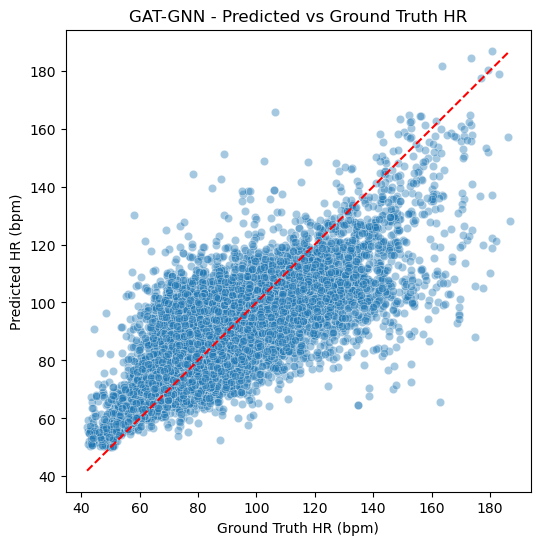

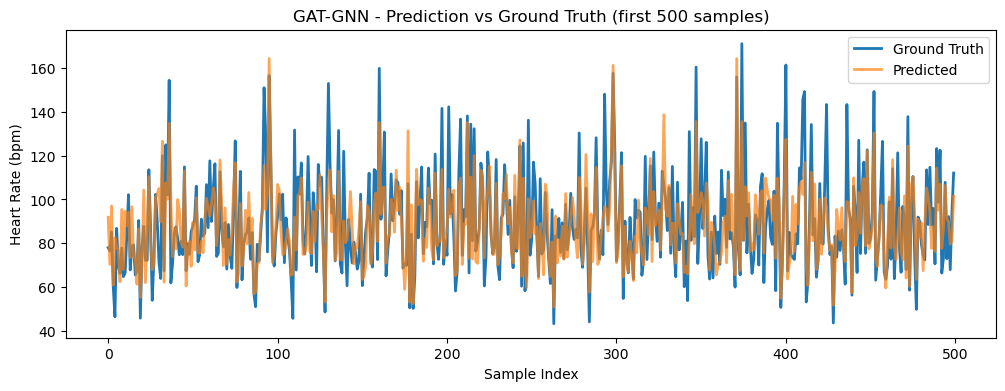

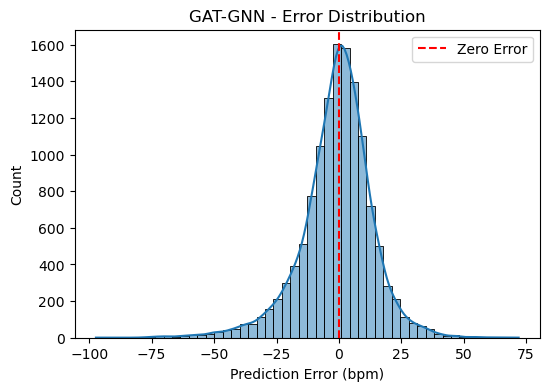

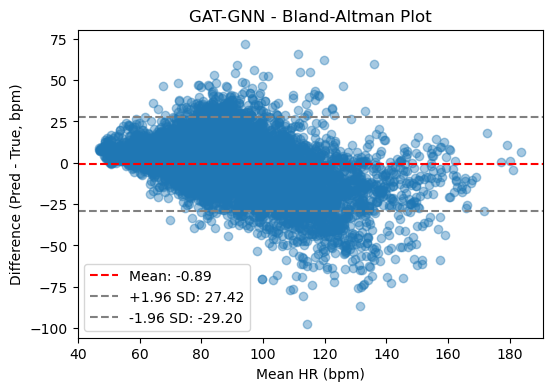


Error Statistics:
  Mean Error: -0.89 bpm
  Std Error: 14.44 bpm
  MAE: 10.44 bpm
  RMSE: 14.47 bpm
  R²: 0.591


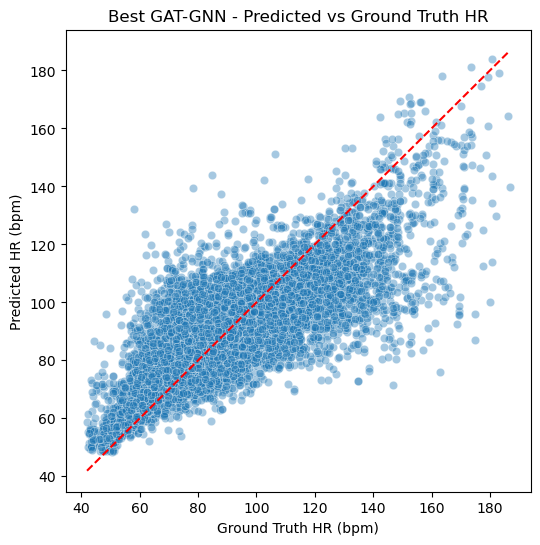

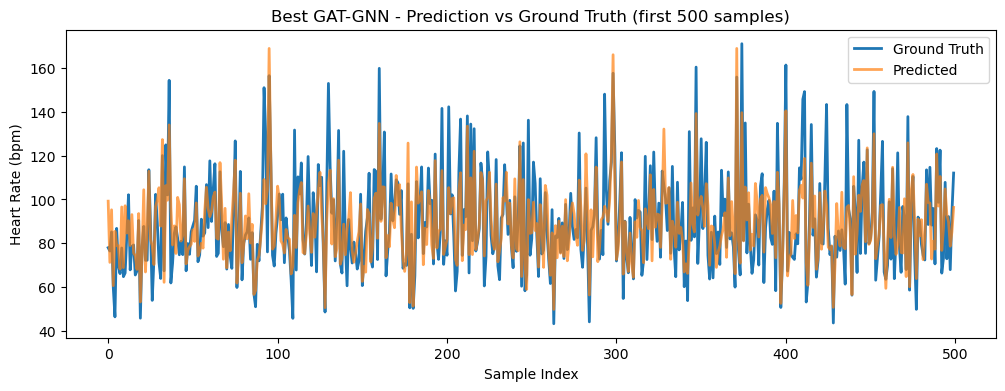

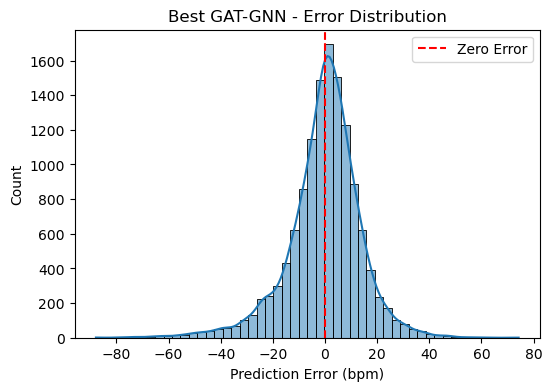

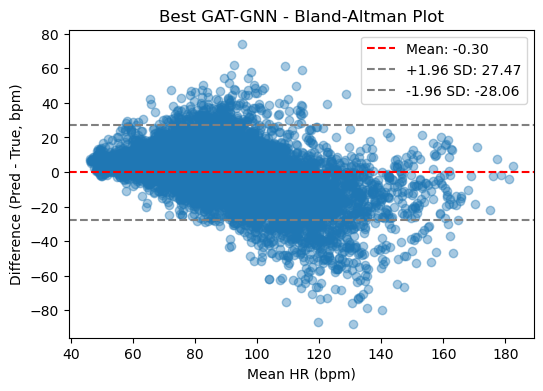


Error Statistics:
  Mean Error: -0.30 bpm
  Std Error: 14.16 bpm
  MAE: 10.15 bpm
  RMSE: 14.17 bpm
  R²: 0.608


In [9]:
# ============================================================================
# VISUALIZATION AND EVALUATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(y_test, y_pred, sample_range=500, title_prefix="GNN"):
    """Comprehensive model evaluation with visualizations."""
    
    # 1. Scatter Plot - Predicted vs Ground Truth
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Ground Truth HR (bpm)")
    plt.ylabel("Predicted HR (bpm)")
    plt.title(f"{title_prefix} - Predicted vs Ground Truth HR")
    plt.show()
    
    # 2. Time Series Comparison (first N samples)
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:sample_range], label="Ground Truth", lw=2)
    plt.plot(y_pred[:sample_range], label="Predicted", lw=2, alpha=0.7)
    plt.xlabel("Sample Index")
    plt.ylabel("Heart Rate (bpm)")
    plt.title(f"{title_prefix} - Prediction vs Ground Truth (first {sample_range} samples)")
    plt.legend()
    plt.show()
    
    # 3. Error Distribution
    errors = y_pred - y_test
    plt.figure(figsize=(6,4))
    sns.histplot(errors, bins=50, kde=True)
    plt.xlabel("Prediction Error (bpm)")
    plt.title(f"{title_prefix} - Error Distribution")
    plt.axvline(0, color='red', linestyle='--', label='Zero Error')
    plt.legend()
    plt.show()
    
    # 4. Bland-Altman Plot
    mean_hr = (y_test + y_pred) / 2
    diff_hr = y_pred - y_test
    plt.figure(figsize=(6,4))
    plt.scatter(mean_hr, diff_hr, alpha=0.4)
    plt.axhline(np.mean(diff_hr), color='red', linestyle='--', label=f'Mean: {np.mean(diff_hr):.2f}')
    plt.axhline(np.mean(diff_hr) + 1.96*np.std(diff_hr), color='gray', linestyle='--', 
                label=f'+1.96 SD: {np.mean(diff_hr) + 1.96*np.std(diff_hr):.2f}')
    plt.axhline(np.mean(diff_hr) - 1.96*np.std(diff_hr), color='gray', linestyle='--', 
                label=f'-1.96 SD: {np.mean(diff_hr) - 1.96*np.std(diff_hr):.2f}')
    plt.xlabel("Mean HR (bpm)")
    plt.ylabel("Difference (Pred - True, bpm)")
    plt.title(f"{title_prefix} - Bland-Altman Plot")
    plt.legend()
    plt.show()
    
    # Print statistics
    print("\nError Statistics:")
    print(f"  Mean Error: {np.mean(errors):.2f} bpm")
    print(f"  Std Error: {np.std(errors):.2f} bpm")
    print(f"  MAE: {np.mean(np.abs(errors)):.2f} bpm")
    print(f"  RMSE: {np.sqrt(np.mean(errors**2)):.2f} bpm")
    print(f"  R²: {r2_score(y_test, y_pred):.3f}")

# Run evaluation on trained model
evaluate_model(y_test, y_pred_gnn, sample_range=500, title_prefix="GAT-GNN")

# If you ran hyperparameter tuning, evaluate the best model
if RUN_HP_TUNING:
    evaluate_model(y_test, y_pred_best_gnn, sample_range=500, title_prefix="Best GAT-GNN")

In [10]:
# ============================================================================
# HELPER: RESUME TRAINING FROM CHECKPOINT
# ============================================================================

# Use this cell if you need to resume training after interruption

# Example usage:
# 1. Find your checkpoint directory
# 2. Set the path to the checkpoint you want to resume from
# 3. Run train_gnn with resume_from parameter

# Example:
CHECKPOINT_PATH = None  # Set to your checkpoint path, e.g., 'saved_models/checkpoints/training_20240101_120000/checkpoint_epoch_0200.pt'

if CHECKPOINT_PATH is not None:
    print(f"Resuming training from: {CHECKPOINT_PATH}\n")
    
    resumed_model, resumed_y_pred, resumed_checkpoint_dir = train_gnn(
        train_data,
        test_data,
        epochs=500,  # Total epochs (will start from checkpoint epoch)
        lr=0.001,
        hidden_channels=64,
        heads=4,
        dropout=0.3,
        checkpoint_freq=50,
        resume_from=CHECKPOINT_PATH
    )
else:
    print("No checkpoint specified. Set CHECKPOINT_PATH to resume training.")

No checkpoint specified. Set CHECKPOINT_PATH to resume training.


## Training Summary

### Key Features:

1. **Automatic Checkpointing**
   - Saves model every 50 epochs (configurable)
   - Best model saved whenever performance improves
   - All checkpoints include optimizer state for resuming

2. **Resume Capability**
   - Can resume training from any checkpoint
   - Preserves training history and optimizer state
   - Simply set `resume_from` parameter

3. **Hyperparameter Tuning**
   - Tests multiple configurations automatically
   - Saves all models (optional) or just best
   - Tracks results in JSON format

4. **Model Organization**
   - All files organized by timestamp
   - Configuration saved with each model
   - Easy to identify and load models

### Directory Structure:
```
saved_models/
├── checkpoints/
│   └── training_YYYYMMDD_HHMMSS/
│       ├── best_model.pt
│       ├── checkpoint_epoch_0050.pt
│       ├── checkpoint_epoch_0100.pt
│       ├── config.json
│       └── training_history.json
└── hyperparameter_tuning/
    └── tuning_YYYYMMDD_HHMMSS/
        ├── BEST_MODEL_mae_X.XX.pt
        ├── model_001_mae_X.XX.pt
        ├── model_002_mae_X.XX.pt
        └── tuning_results.json
```

In [15]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
def evaluate_regressor(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }

baseline_results = []

baseline_results.append(
    evaluate_regressor(
        RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            n_jobs=-1,
            random_state=42,
        ),
        "Random Forest",
        X_train,
        y_train,
        X_test,
        y_test,
    )
)

baseline_results.append(
    evaluate_regressor(
        GradientBoostingRegressor(random_state=42),
        "Gradient Boosting",
        X_train,
        y_train,
        X_test,
        y_test,
    )
)

baseline_results.append(
    evaluate_regressor(
        MLPRegressor(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            max_iter=200,
            random_state=42,
        ),
        "MLP Regressor",
        X_train,
        y_train,
        X_test,
        y_test,
    )
)

y_true = np.asarray(y_test).reshape(-1)
y_pred_gnn_flat = np.asarray(y_pred_gnn).reshape(-1)

gnn_mae = mean_absolute_error(y_true, y_pred_gnn_flat)
gnn_rmse = np.sqrt(mean_squared_error(y_true, y_pred_gnn_flat))
gnn_r2 = r2_score(y_true, y_pred_gnn_flat)

baseline_results.append(
    {
        "Model": "GAT-GNN",
        "MAE": gnn_mae,
        "RMSE": gnn_rmse,
        "R2": gnn_r2,
    }
)

results_df = pd.DataFrame(baseline_results)
results_df

C:\Users\pedri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,MAE,RMSE,R2
0,Random Forest,6.163327,9.709894,0.815968
1,Gradient Boosting,9.524383,13.561101,0.641033
2,MLP Regressor,7.939207,11.350239,0.748537
3,GAT-GNN,10.435671,14.472134,0.591182


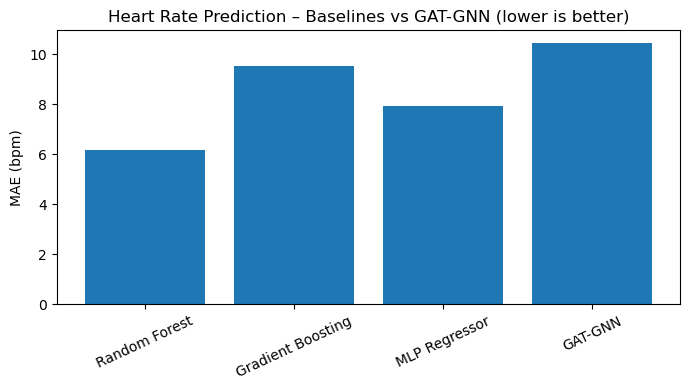

In [17]:
plt.figure(figsize=(7, 4))
plt.bar(results_df["Model"], results_df["MAE"])
plt.ylabel("MAE (bpm)")
plt.title("Heart Rate Prediction – Baselines vs GAT-GNN (lower is better)")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [18]:
baseline_mae = results_df.loc[results_df["Model"] != "GAT-GNN", "MAE"].mean()

print("=== Comparison Summary ===")
for _, row in results_df.iterrows():
    print(
        f"{row['Model']:15s}  MAE: {row['MAE']:.2f} bpm  "
        f"RMSE: {row['RMSE']:.2f} bpm  R²: {row['R2']:.3f}"
    )

improvement = (baseline_mae - gnn_mae) / baseline_mae * 100
print("\nAverage baseline MAE:", f"{baseline_mae:.2f} bpm")
print("GAT-GNN MAE:", f"{gnn_mae:.2f} bpm")
print(f"Relative improvement of GAT-GNN vs average baseline: {improvement:.1f}%")

=== Comparison Summary ===
Random Forest    MAE: 6.16 bpm  RMSE: 9.71 bpm  R²: 0.816
Gradient Boosting  MAE: 9.52 bpm  RMSE: 13.56 bpm  R²: 0.641
MLP Regressor    MAE: 7.94 bpm  RMSE: 11.35 bpm  R²: 0.749
GAT-GNN          MAE: 10.44 bpm  RMSE: 14.47 bpm  R²: 0.591

Average baseline MAE: 7.88 bpm
GAT-GNN MAE: 10.44 bpm
Relative improvement of GAT-GNN vs average baseline: -32.5%


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

In [21]:
# Ground truth and predictions from your existing model
y_true = test_data.y.cpu().numpy().squeeze()
y_pred = np.asarray(y_pred_gnn).squeeze()

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

bins = {
    "Low HR (< 80 bpm)": y_true < 80,
    "Medium HR (80–120 bpm)": (y_true >= 80) & (y_true <= 120),
    "High HR (> 120 bpm)": y_true > 120,
}

range_rows = []
for name, mask in bins.items():
    count = int(mask.sum())
    if count == 0:
        continue
    yt = y_true[mask]
    yp = y_pred[mask]
    mae = mean_absolute_error(yt, yp)
    rmse = np.sqrt(mean_squared_error(yt, yp))
    r2 = r2_score(yt, yp)
    range_rows.append(
        {
            "Range": name,
            "Count": count,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2,
        }
    )

hr_range_df = pd.DataFrame(range_rows)
hr_range_df

y_true shape: (12940,)
y_pred shape: (12940,)


,Range,Count,MAE,RMSE,R2
0,Low HR (< 80 bpm),5073,8.561082,11.971665,-1.183585
1,Medium HR (80–120 bpm),6475,8.975519,11.408659,-0.131127
2,High HR (> 120 bpm),1392,24.059435,28.621991,-3.334410


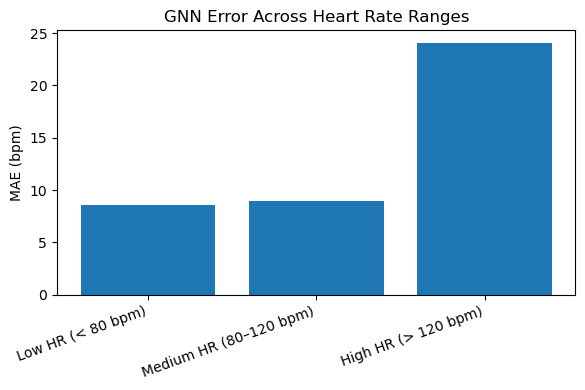

                    Range  Count        MAE       RMSE        R2
0       Low HR (< 80 bpm)   5073   8.561082  11.971665 -1.183585
1  Medium HR (80–120 bpm)   6475   8.975519  11.408659 -0.131127
2     High HR (> 120 bpm)   1392  24.059435  28.621991 -3.334410


In [22]:
plt.figure(figsize=(6, 4))
plt.bar(hr_range_df["Range"], hr_range_df["MAE"])
plt.ylabel("MAE (bpm)")
plt.title("GNN Error Across Heart Rate Ranges")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

print(hr_range_df)

Heart Rate Range Error Breakdown
--------------------------------
< 80 bpm   | n= 5073 | MAE=  8.56 bpm | RMSE= 11.97 bpm
80–120 bpm | n= 6475 | MAE=  8.98 bpm | RMSE= 11.41 bpm
> 120 bpm  | n= 1392 | MAE= 24.06 bpm | RMSE= 28.62 bpm


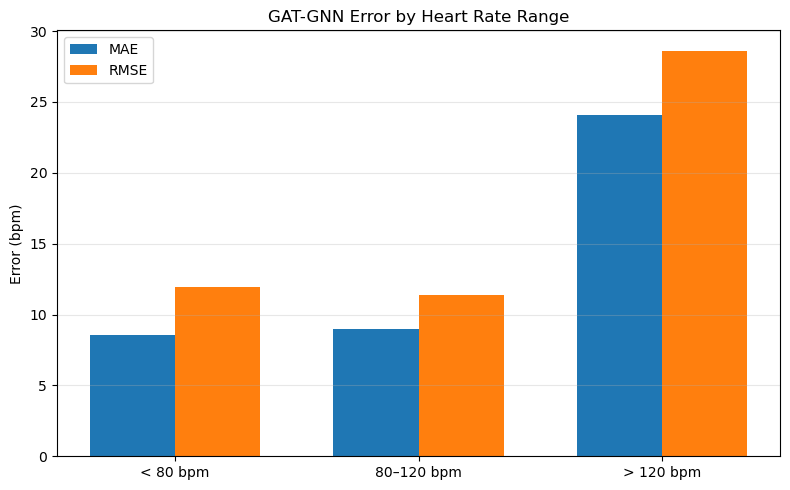

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Ground truth and predictions
y_true = test_data.y.cpu().numpy().squeeze()
y_pred = np.array(y_pred_gnn).squeeze()

# Define HR ranges
ranges = [(0, 80), (80, 120), (120, 300)]
labels = ["< 80 bpm", "80–120 bpm", "> 120 bpm"]

maes = []
rmses = []
counts = []

for (low, high), label in zip(ranges, labels):
    idx = (y_true >= low) & (y_true < high)
    n = np.sum(idx)
    counts.append(int(n))
    if n == 0:
        maes.append(np.nan)
        rmses.append(np.nan)
        continue

    err = y_pred[idx] - y_true[idx]
    mae = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    maes.append(mae)
    rmses.append(rmse)

print("Heart Rate Range Error Breakdown")
print("--------------------------------")
for lab, n, mae, rmse in zip(labels, counts, maes, rmses):
    print(f"{lab:10s} | n={n:5d} | MAE={mae:6.2f} bpm | RMSE={rmse:6.2f} bpm")

# Bar plot
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, maes, width, label="MAE")
plt.bar(x + width/2, rmses, width, label="RMSE")
plt.xticks(x, labels)
plt.ylabel("Error (bpm)")
plt.title("GAT-GNN Error by Heart Rate Range")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

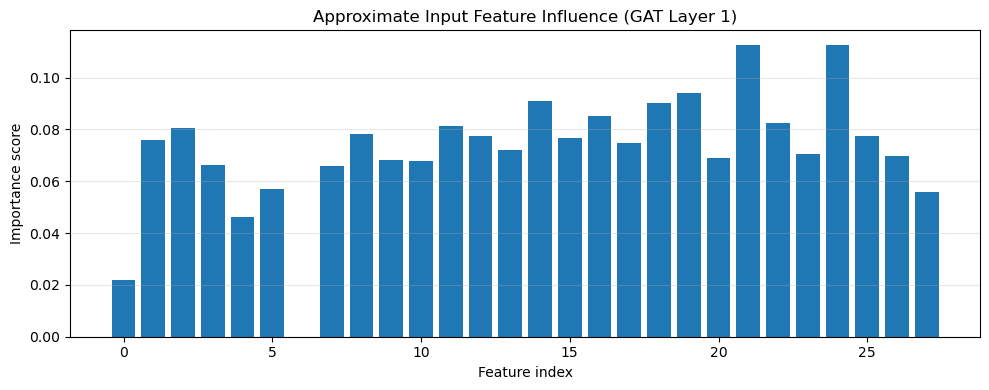

Top 10 most important input features (by index and score):
 1) Feature  21  importance=0.1126
 2) Feature  24  importance=0.1125
 3) Feature  19  importance=0.0942
 4) Feature  14  importance=0.0908
 5) Feature  18  importance=0.0901
 6) Feature  16  importance=0.0850
 7) Feature  22  importance=0.0823
 8) Feature  11  importance=0.0813
 9) Feature   2  importance=0.0806
10) Feature   8  importance=0.0783


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

gnn_model.eval()
device = next(gnn_model.parameters()).device

gat_layer = gnn_model.conv1

if hasattr(gat_layer, "lin_src") and gat_layer.lin_src is not None:
    W = gat_layer.lin_src.weight.detach().cpu().numpy()
elif hasattr(gat_layer, "lin_l") and gat_layer.lin_l is not None:
    W = gat_layer.lin_l.weight.detach().cpu().numpy()
else:
    W = gat_layer.lin.weight.detach().cpu().numpy()

importance = np.mean(np.abs(W), axis=0)

plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(importance)), importance)
plt.xlabel("Feature index")
plt.ylabel("Importance score")
plt.title("Approximate Input Feature Influence (GAT Layer 1)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

top_idx = np.argsort(-importance)[:10]
print("Top 10 most important input features (by index and score):")
for i, idx in enumerate(top_idx, 1):
    print(f"{i:2d}) Feature {idx:3d}  importance={importance[idx]:.4f}")


In [33]:
import torch
import numpy as np

gnn_model.eval()
device = next(gnn_model.parameters()).device

with torch.no_grad():
    x = test_data.x.to(device)
    edge_index = test_data.edge_index.to(device)

    out, (edge_att, alpha) = gnn_model.conv1(
        x,
        edge_index,
        return_attention_weights=True
    )

alpha = alpha.detach().cpu().numpy()          # shape: [num_edges, num_heads] or [num_heads, num_edges]
edge_att = edge_att.cpu().numpy()            # shape: [2, num_edges]

if alpha.ndim == 2:
    # average over heads -> one score per edge
    if alpha.shape[0] == edge_att.shape[1]:
        alpha_mean = alpha.mean(axis=1)
    else:
        alpha_mean = alpha.mean(axis=0)
else:
    alpha_mean = alpha

top_k = 20
idx = np.argsort(-alpha_mean)[:top_k]        # sort by strongest attention (descending)

print("\nTop Attention Edges (GAT Layer 1):")
for rank, i in enumerate(idx, start=1):
    src = edge_att[0, i]
    dst = edge_att[1, i]
    att = alpha_mean[i]
    print(f"{rank:2d}) src={src:5d} -> dst={dst:5d} | attention={att:.4f}")



Top Attention Edges (GAT Layer 1):
 1) src= 4129 -> dst= 4129 | attention=1.0000
 2) src= 4492 -> dst= 4492 | attention=1.0000
 3) src= 6754 -> dst= 6754 | attention=1.0000
 4) src=12381 -> dst=12381 | attention=1.0000
 5) src= 3044 -> dst= 3044 | attention=1.0000
 6) src= 6560 -> dst= 6560 | attention=1.0000
 7) src= 3013 -> dst= 3013 | attention=1.0000
 8) src= 4528 -> dst= 4528 | attention=1.0000
 9) src= 2981 -> dst= 2981 | attention=1.0000
10) src= 6365 -> dst= 6365 | attention=1.0000
11) src= 7010 -> dst= 7010 | attention=1.0000
12) src= 6311 -> dst= 6311 | attention=1.0000
13) src= 6261 -> dst= 6261 | attention=1.0000
14) src= 6252 -> dst= 6252 | attention=1.0000
15) src= 6225 -> dst= 6225 | attention=1.0000
16) src= 6187 -> dst= 6187 | attention=1.0000
17) src=12472 -> dst=12472 | attention=1.0000
18) src=12477 -> dst=12477 | attention=1.0000
19) src= 6092 -> dst= 6092 | attention=1.0000
20) src= 6038 -> dst= 6038 | attention=1.0000


In [ ]:
D